In [1]:
import abc
import time
import typing
import warnings

import tqdm
import torch
import wandb
import random
import pandas
import torchscan
import torchvision
import sklearn.metrics
import matplotlib.pyplot as plt
import torch.utils.data as torchdata

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

RANDOM_STATE = 42
def set_random_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
def fix_random():
    return set_random_seed(RANDOM_STATE)
fix_random()

cuda


In [2]:
wandb.login(anonymous = "allow")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ttpo100ajiex (hse-iad). Use `wandb login --relogin` to force relogin


True

# 1. Train the CNN based classifier

## Load the dataset


In [3]:
fix_random()

# Transforms
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean = torch.tensor([ 0.491, 0.482, 0.447 ]),
        std = torch.tensor([ 0.247, 0.244, 0.262 ])
    )
])

# Load dataset
train_set = torchvision.datasets.CIFAR10('cifar-10', train = True, download = True, transform = transforms)
test_set = torchvision.datasets.CIFAR10('cifar-10', train = False, download = True, transform = transforms)

# Split train dataset into train and val
train_set, val_set = torchdata.random_split(train_set, [ len(train_set) - 5000, 5000 ])

# Extract labels
labels = test_set.classes

# Check
print(len(train_set), len(val_set), len(test_set))
print(labels)

Files already downloaded and verified
Files already downloaded and verified
45000 5000 10000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


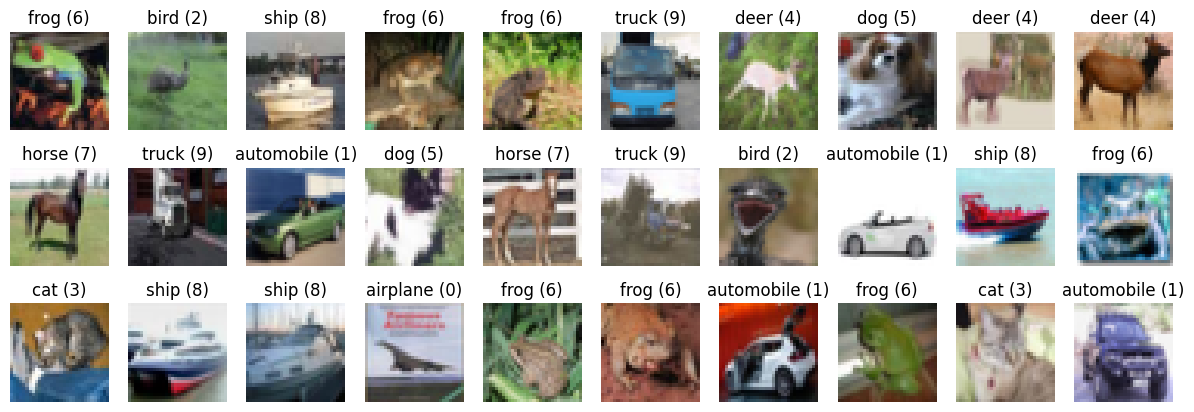

In [4]:
# Denormalization
denormalize = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(
        mean = [ 0., 0., 0. ],
        std = 1 / transforms.transforms[1].std
    ),
    torchvision.transforms.Normalize(
        mean = -transforms.transforms[1].mean,
        std = [ 1., 1., 1. ]
    )
])

# Display some samples
plt.rcParams["figure.figsize"] = (15, 5)
for i in range(10):
    image, class_num = train_set[i]
    plt.subplot(3, 10, i + 1)
    plt.axis('off')
    plt.imshow(denormalize(image).permute(1, 2, 0))
    plt.title('{} ({})'.format(labels[class_num], str(class_num)))

for i in range(10):
    image, class_num = val_set[i]
    plt.subplot(3, 10, i + 11)
    plt.axis('off')
    plt.imshow(denormalize(image).permute(1, 2, 0))
    plt.title('{} ({})'.format(labels[class_num], str(class_num)))

for i in range(10):
    image, class_num = test_set[i]
    plt.subplot(3, 10, i + 21)
    plt.axis('off')
    plt.imshow(denormalize(image).permute(1, 2, 0))
    plt.title('{} ({})'.format(labels[class_num], str(class_num)))

## Function for accuracy checking

In [5]:
class BaseClassifier(abc.ABC):
    @abc.abstractmethod
    def fit(self, dataset: torchdata.Dataset):
        raise NotImplementedError

    @abc.abstractmethod
    def predict(self, images: torch.Tensor) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        raise NotImplementedError
    
    def calc_metrics(self, dataset: torchdata.Dataset) -> dict:
        all_true = torch.tensor([])
        all_scores = torch.empty((0, 10))
        all_predictions = torch.tensor([])
        loader = torchdata.DataLoader(dataset, batch_size = 512, shuffle = False)
        for images, labels in loader:
            all_true = torch.cat([ all_true, labels ])
            predictions, scores = self.predict(images)
            all_scores = torch.cat([ all_scores, scores.detach().cpu() ])
            all_predictions = torch.cat([ all_predictions, predictions.detach().cpu() ])

        return {
            '': '',
            'Accuracy':       sklearn.metrics.accuracy_score      (all_true, all_predictions),
            'TOP-2 Accuracy': sklearn.metrics.top_k_accuracy_score(all_true, all_scores, k = 2),
            'TOP-3 Accuracy': sklearn.metrics.top_k_accuracy_score(all_true, all_scores, k = 3),
            'TOP-4 Accuracy': sklearn.metrics.top_k_accuracy_score(all_true, all_scores, k = 4),
            'TOP-5 Accuracy': sklearn.metrics.top_k_accuracy_score(all_true, all_scores, k = 5),
            'TOP-6 Accuracy': sklearn.metrics.top_k_accuracy_score(all_true, all_scores, k = 6),
            'TOP-7 Accuracy': sklearn.metrics.top_k_accuracy_score(all_true, all_scores, k = 7),
            'TOP-8 Accuracy': sklearn.metrics.top_k_accuracy_score(all_true, all_scores, k = 8),
            'TOP-9 Accuracy': sklearn.metrics.top_k_accuracy_score(all_true, all_scores, k = 9),
            'AUC-ROC':        sklearn.metrics.roc_auc_score       (all_true, all_scores, multi_class = 'ovo'),
            'Precision':      sklearn.metrics.precision_score     (all_true, all_predictions, average = 'macro'),
            'Recall':         sklearn.metrics.recall_score        (all_true, all_predictions, average = 'macro'),
            'F1-score':       sklearn.metrics.f1_score            (all_true, all_predictions, average = 'macro')
        }

## Implement CNN class for CIFAR10

In [6]:
class Classifier(BaseClassifier):
    results = [ ]

    def __init__(
            self,
            name: str,
            model: torch.nn.Module,
            batch_size: int = 256,
            learning_rate: float = 1e-4,
            device: torch.device = device,
            optimizer: typing.Optional[torch.optim.Optimizer] = None,
            scheduler: typing.Optional[torch.optim.lr_scheduler.LRScheduler] = None,
        ):
        self.name = name
        self.history = [ ]
        self.device = device
        self.input_shape = None
        self.scheduler = scheduler
        self.batch_size = batch_size
        self.model = model.to(self.device)
        self.optimizer = optimizer or torch.optim.AdamW(self.model.parameters(), lr = learning_rate)


    def train(self, images: torch.Tensor, labels: torch.Tensor) -> float:
        self.model.train() # Enter train mode
        self.optimizer.zero_grad() # Zero gradients
        output = self.model(images.to(self.device)) # Get predictions
        loss = torch.nn.functional.cross_entropy(output, labels.to(self.device)) # Calculate loss
        loss.backward() # Calculate gradients
        self.optimizer.step() # Update weights
        return loss.item()

    def train_epoch(self, loader: torchdata.DataLoader) -> float:
        sum_loss = 0
        for images, labels in loader:
            sum_loss += self.train(images, labels) # Train on one batch
        if self.scheduler is not None:
            self.scheduler.step()
        return sum_loss / len(loader) # Return average loss to avoid highly random-dependent graph
       
    def fit(self, train_set: torchdata.Dataset, val_set: torchdata.Dataset, n_epochs: int = 1):
        self.input_shape = train_set[0][0].shape
        loader = torchdata.DataLoader(train_set, batch_size = self.batch_size, shuffle = True)
        wandb.init(project = "CV-HW-4", name = self.name, anonymous = "allow")
        wandb.watch(self.model, log = "all")
        for epoch in tqdm.trange(n_epochs):
            # Train
            train_start = time.perf_counter()
            loss = self.train_epoch(loader)
            train_time = time.perf_counter() - train_start

            # Validate
            val_start = time.perf_counter()
            metrics = self.calc_metrics(val_set)
            val_time = time.perf_counter() - val_start
            
            # Upload metrics
            metrics['Validation time'] = val_time
            metrics['Train time'] = train_time
            metrics['Loss'] = loss
            wandb.log(metrics)
            metrics['Epoch'] = epoch + 1
            self.history.append(metrics)

        # Finish the run
        wandb.finish()

        # Store best metrics
        best_metrics = max(self.history, key = lambda item: item['Accuracy'])
        Classifier.results.append({ **best_metrics, 'Name': self.name })

        return self
    

    def predict(self, images: torch.Tensor) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        self.model.eval() # Enter evaluation mode
        with torch.no_grad():
            outputs = self.model(images.to(self.device)) # Get outputs
            scores = torch.softmax(outputs, dim = 1) # Make probabilities
            predictions = torch.argmax(scores, dim = 1) # Calculate predictions
        return predictions, scores
    

    def summary(self, test_set: torchdata.Dataset):
        warnings.filterwarnings("ignore")
        display(pandas.DataFrame(Classifier.results).set_index("Name"))
        torchscan.summary(self.model.eval(), self.input_shape, receptive_field = True)
        return pandas.DataFrame([ self.calc_metrics(test_set) ])

**In constructor**

Define 2 - 3 convolutional layers

 https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

with corresponding in/out dimensions W_out = 1 + ((W_in - F + 2*P) / S)


Also define max pooling : https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

and fully connected layers: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear


**In forward**

Write code for forward pass.
Remember that first dimension is the batch dimension

In [12]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 7, padding = 1),
    torch.nn.BatchNorm2d(16),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.GELU(),
    
    torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, padding = 1),
    torch.nn.BatchNorm2d(32),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.GELU(),
    
    torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
    torch.nn.BatchNorm2d(32),
    torch.nn.GELU(),
    
    torch.nn.Flatten(),

    torch.nn.Dropout(0.5),
    torch.nn.Linear(32 * 6 * 6, 250),
    torch.nn.BatchNorm1d(250),
    torch.nn.GELU(),
    
    torch.nn.Dropout(0.2),
    torch.nn.Linear(250, 64),
    torch.nn.BatchNorm1d(64),
    torch.nn.GELU(),
    
    torch.nn.Linear(64, 10),
).to(device)
model = Classifier('Intial model', model, learning_rate = 1e-3).fit(train_set, val_set, 25)

100%|██████████| 25/25 [03:00<00:00,  7.22s/it]


AUC-ROC,▁▄▅▅▅▆▆▇▇▇▇▇█▇███████████
Accuracy,▁▃▄▄▅▅▅▆▇▆▇▇▇▇▇▇▇█▇██████
F1-score,▁▃▄▄▅▅▅▆▇▆▇▇▇▇▇▇▇█▇██████
Loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Precision,▁▃▄▄▅▆▅▆▇▆▇▇▇▇▇▇▇█▇██████
Recall,▁▃▄▄▅▅▅▆▇▆▇▇▇▇▇▇▇█▇██████
TOP-2 Accuracy,▁▄▄▅▅▅▅▆▇▇▇▇▇▇▇█▇█▇██████
TOP-3 Accuracy,▁▄▅▅▅▅▆▆▇▇▇▇▇▇▇█▇████████
TOP-4 Accuracy,▁▄▅▅▅▅▅▆▇▇▇▇██▇███▇██████
TOP-5 Accuracy,▁▄▅▅▅▅▆▆▇▇▇▇█▇▇███▇█████▇
TOP-6 Accuracy,▁▄▄▅▅▅▆▆▇▇▇▇█▇▇█▇█▇██▇▇▇█


## Train the model




### Validat results on test dataset

You must get accuracy above 0.65

In [13]:
model.summary(test_set)

,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score,Validation time,Train time,Loss,Epoch
Name,,,,,,,,,,,,,,,,,,
Intial model,,0.7192,0.8696,0.9322,0.9618,0.9806,0.9906,0.9948,0.9978,0.9988,0.960430,0.718605,0.718283,0.717466,0.641605,6.683329,0.786203,25
Intial model,,0.7654,0.9004,0.9466,0.9738,0.9852,0.9922,0.9954,0.9972,0.9988,0.971100,0.764274,0.764669,0.763747,0.635798,6.832672,0.519895,24
Intial model,,0.7732,0.9032,0.9518,0.9722,0.9838,0.9926,0.9960,0.9982,0.9990,0.972942,0.772092,0.772565,0.771524,0.628348,6.866686,0.451799,25


____________________________________________________________________________________________________________
Layer                        Type                  Output Shape              Param #         Receptive field
sequential                   Sequential            (-1, 10)                  0               26             
├─0                          Conv2d                (-1, 16, 28, 28)          2,368           26             
├─1                          BatchNorm2d           (-1, 16, 28, 28)          65              20             
├─2                          MaxPool2d             (-1, 16, 14, 14)          0               20             
├─3                          GELU                  (-1, 16, 14, 14)          0               10             
├─4                          Conv2d                (-1, 32, 12, 12)          12,832          10             
├─5                          BatchNorm2d           (-1, 32, 12, 12)          129             6              
├─6                

,,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,,0.7681,0.8966,0.9466,0.9717,0.984,0.991,0.9954,0.9977,0.9994,0.971228,0.767578,0.7681,0.767367


# 2. Compare different Normalization methods

* Add extra conv layer to your model (3-7)
* Take three different normalization layers: BatchNorm, InstanceNorm, LayerNorm
* Train the model with each of them.
* Plot the loss curve for different normalization in same axis


*Because this task is time consuming it is recommended to perform calculations on a small piece of datastat*

In [9]:
# Put your code here ...

# Place for brief conclusion:

....


# Ideas for extra work

---
1. Evaluate the impact of the number and size of filters in convolutional layers on the accuracy.

2. Evaluate the impact of the convolutional layers count on the accuracy.

3. Visualize something: filters, activations ...

---







